In [81]:
!pip install pandas==1.5.3

import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

print(pd.__version__)

1.5.3


In [82]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 126D-D836

 Directory of C:\Users\smufl\Downloads\Day2\LST_SVM

27/04/2024  19:47    <DIR>          .
27/04/2024  19:30    <DIR>          ..
27/04/2024  19:38    <DIR>          .ipynb_checkpoints
27/04/2024  19:47           178,380 LST_forecasting_SVM.ipynb
27/04/2024  19:27            36,538 modis_ndvi_series_LST.csv
               2 File(s)        214,918 bytes
               3 Dir(s)  809,772,822,528 bytes free


In [83]:
data = pd.read_csv('modis_ndvi_series_LST.csv')
data = data.filter(regex=r'loc|20')
data.head()

,20180101A,20180101D,20180102A,20180102D,20180103A,20180103D,20180104A,20180104D,20180105A,20180105D,...,20200623D,20200624A,20200624D,20200625A,20200625D,20200626A,20200626D,20200627A,20200627D,loc
0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,1.65,1.5,1.64,1.5,1.62,-9999,-9999,1.49,1.66,L1
1,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,1.65,1.5,1.64,1.5,1.62,-9999,-9999,1.49,1.66,L2


# Computing annual means to remove seasonality.


In [84]:
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt=melt[(melt['NDVI']>0)]   # remove negative values

# get locations

melt['location'] = melt['loc'].str.extract('(\d+)', expand=False).astype(int)
melt['year'] = melt['day'].str.extract('(\d+)', expand=False).astype(int)
print(melt)

melt = melt.sort_values(['location', 'year'])
# Computing annual means 

year_mean=melt.groupby(['year', 'loc']).mean()
year_mean=year_mean.reset_index()
year_mean

     loc        day  NDVI  location      year
84    L1  20180122D  1.34         1  20180122
85    L2  20180122D  1.34         2  20180122
88    L1  20180123D  1.41         1  20180123
89    L2  20180123D  1.41         2  20180123
92    L1  20180124D  1.45         1  20180124
...   ..        ...   ...       ...       ...
3585  L2  20200625D  1.62         2  20200625
3590  L1  20200627A  1.49         1  20200627
3591  L2  20200627A  1.49         2  20200627
3592  L1  20200627D  1.66         1  20200627
3593  L2  20200627D  1.66         2  20200627

[2648 rows x 5 columns]


C:\Users\smufl\AppData\Local\Temp\ipykernel_15956\2166230131.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mean=melt.groupby(['year', 'loc']).mean()


,year,loc,NDVI,location
0,20180122,L1,1.340,1.0
1,20180122,L2,1.340,2.0
2,20180123,L1,1.410,1.0
3,20180123,L2,1.410,2.0
4,20180124,L1,1.450,1.0
...,...,...,...,...
1467,20200624,L2,1.570,2.0
1468,20200625,L1,1.560,1.0
1469,20200625,L2,1.560,2.0
1470,20200627,L1,1.575,1.0


# Split dataset

In [85]:
year_mean.index

RangeIndex(start=0, stop=1472, step=1)

In [86]:
split_point = 28
melt_train = year_mean[year_mean.index < split_point].copy()
melt_valid = year_mean[year_mean.index >= split_point].copy()

In [87]:
melt_train

,year,loc,NDVI,location
0,20180122,L1,1.34,1.0
1,20180122,L2,1.34,2.0
2,20180123,L1,1.41,1.0
3,20180123,L2,1.41,2.0
4,20180124,L1,1.45,1.0
5,20180124,L2,1.45,2.0
6,20180125,L1,1.41,1.0
7,20180125,L2,1.41,2.0
8,20180126,L1,1.42,1.0
9,20180126,L2,1.42,2.0


In [88]:
melt_valid

,year,loc,NDVI,location
28,20180307,L1,1.420,1.0
29,20180307,L2,1.420,2.0
30,20180308,L1,1.435,1.0
31,20180308,L2,1.435,2.0
32,20180309,L1,1.420,1.0
...,...,...,...,...
1467,20200624,L2,1.570,2.0
1468,20200625,L1,1.560,1.0
1469,20200625,L2,1.560,2.0
1470,20200627,L1,1.575,1.0


# Creating Features and Targets

In [89]:
melt_train['lead1'] = melt_train.groupby("loc")['NDVI'].shift(-1).fillna(0)
melt_train['lead2'] = melt_train.groupby("loc")['NDVI'].shift(-2).fillna(0)
melt_train['lead3'] = melt_train.groupby("loc")['NDVI'].shift(-3).fillna(0)
melt_train['lead4'] = melt_train.groupby("loc")['NDVI'].shift(-4).fillna(0)
melt_train['lead5'] = melt_train.groupby("loc")['NDVI'].shift(-5).fillna(0)

melt_train['lag1'] = melt_train.groupby("loc")['NDVI'].shift(1).fillna(0)
melt_train['lag2'] = melt_train.groupby("loc")['NDVI'].shift(2).fillna(0)
melt_train['lag3'] = melt_train.groupby("loc")['NDVI'].shift(3).fillna(0)

melt_train["diff_1"] = melt_train.groupby("loc")['NDVI'].diff(1).fillna(0)

melt_train

,year,loc,NDVI,location,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
0,20180122,L1,1.34,1.0,1.41,1.45,1.41,1.42,1.42,0.00,0.00,0.00,0.00
1,20180122,L2,1.34,2.0,1.41,1.45,1.41,1.42,1.42,0.00,0.00,0.00,0.00
2,20180123,L1,1.41,1.0,1.45,1.41,1.42,1.42,1.42,1.34,0.00,0.00,0.07
3,20180123,L2,1.41,2.0,1.45,1.41,1.42,1.42,1.42,1.34,0.00,0.00,0.07
4,20180124,L1,1.45,1.0,1.41,1.42,1.42,1.42,1.47,1.41,1.34,0.00,0.04
5,20180124,L2,1.45,2.0,1.41,1.42,1.42,1.42,1.47,1.41,1.34,0.00,0.04
6,20180125,L1,1.41,1.0,1.42,1.42,1.42,1.47,1.37,1.45,1.41,1.34,-0.04
7,20180125,L2,1.41,2.0,1.42,1.42,1.42,1.47,1.37,1.45,1.41,1.34,-0.04
8,20180126,L1,1.42,1.0,1.42,1.42,1.47,1.37,1.39,1.41,1.45,1.41,0.01
9,20180126,L2,1.42,2.0,1.42,1.42,1.47,1.37,1.39,1.41,1.45,1.41,0.01


In [90]:
melt_valid['lead1'] = melt_valid.groupby("loc")['NDVI'].shift(-1)
melt_valid['lead2'] = melt_valid.groupby("loc")['NDVI'].shift(-2)
melt_valid['lead3'] = melt_valid.groupby("loc")['NDVI'].shift(-3)
melt_valid['lead4'] = melt_valid.groupby("loc")['NDVI'].shift(-4)
melt_valid['lead5'] = melt_valid.groupby("loc")['NDVI'].shift(-5)

melt_valid['lag1'] = melt_valid.groupby("loc")['NDVI'].shift(1)
melt_valid['lag2'] = melt_valid.groupby("loc")['NDVI'].shift(2)
melt_valid['lag3'] = melt_valid.groupby("loc")['NDVI'].shift(3)

melt_valid["diff_1"] = melt_valid.groupby("loc")['NDVI'].diff(1)

melt_valid

,year,loc,NDVI,location,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
28,20180307,L1,1.420,1.0,1.435,1.420,1.45,1.490,1.440,NaN,NaN,NaN,NaN
29,20180307,L2,1.420,2.0,1.435,1.420,1.45,1.490,1.440,NaN,NaN,NaN,NaN
30,20180308,L1,1.435,1.0,1.420,1.450,1.49,1.440,1.445,1.420,NaN,NaN,0.015
31,20180308,L2,1.435,2.0,1.420,1.450,1.49,1.440,1.445,1.420,NaN,NaN,0.015
32,20180309,L1,1.420,1.0,1.450,1.490,1.44,1.445,1.410,1.435,1.420,NaN,-0.015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,20200624,L2,1.570,2.0,1.560,1.575,NaN,NaN,NaN,1.575,1.540,1.550,-0.005
1468,20200625,L1,1.560,1.0,1.575,NaN,NaN,NaN,NaN,1.570,1.575,1.540,-0.010
1469,20200625,L2,1.560,2.0,1.575,NaN,NaN,NaN,NaN,1.570,1.575,1.540,-0.010
1470,20200627,L1,1.575,1.0,NaN,NaN,NaN,NaN,NaN,1.560,1.570,1.575,0.015


In [91]:
# drop rows without target values

#melt_train = melt_train.dropna(subset=['lead1','lead2','lead3','lead4','lead5'])
#melt_train


# Train the model

In [92]:
features = ['NDVI', 'lag1', 'lag2', 'lag3','diff_1']

In [93]:
import time
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor

start_time = time.time()
imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])

ytr = melt_train[['lead1', 'lead2', 'lead3', 'lead4', 'lead5']]

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

multi_svr = MultiOutputRegressor(svr, n_jobs=6)

multi_svr.fit(Xtr, ytr)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time for model training: {execution_time:.2f} seconds")

Execution time for model training: 0.02 seconds


# Predicting NDVI  

In [94]:
Xval = imputer.transform(melt_valid[features])
preds = mdl.predict(Xval)

In [95]:
preds

array([[1.4247, 1.4183, 1.4205, 1.4354, 1.4112],
       [1.4247, 1.4183, 1.4205, 1.4354, 1.4112],
       [1.4231, 1.4202, 1.4116, 1.4355, 1.4156],
       ...,
       [1.4137, 1.434 , 1.4209, 1.3937, 1.4092],
       [1.4122, 1.4334, 1.4215, 1.3947, 1.4096],
       [1.4122, 1.4334, 1.4215, 1.3947, 1.4096]])

In [96]:
preds.shape

(1444, 5)

In [97]:
L1_2022_2026=preds[10]
L2_2022_2026=preds[11]

In [98]:
year_arr=np.arange(2022,2027).reshape(-1,1)
L1_arr=L1_2022_2026.reshape(-1,1)
L1_arr_new=np.concatenate((year_arr, L1_arr),axis=1)
df = pd.DataFrame(L1_arr_new, columns = ['year','NDVI'])
df.loc[:,'year']=df.loc[:,'year'].astype(int)
L1_NDVI=year_mean.loc[year_mean['loc'] == 'L1']
# L1_NDVI.loc[:,'year']=L1_NDVI.loc[:,'year'].astype(int)
L1_NDVI=pd.concat([L1_NDVI, df], ignore_index=True)
L1_NDVI

C:\Users\smufl\AppData\Local\Temp\ipykernel_15956\1238754978.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'year']=df.loc[:,'year'].astype(int)


,year,loc,NDVI,location
0,20180122,L1,1.3400,1.0
1,20180123,L1,1.4100,1.0
2,20180124,L1,1.4500,1.0
3,20180125,L1,1.4100,1.0
4,20180126,L1,1.4200,1.0
...,...,...,...,...
736,2022,NaN,1.4072,NaN
737,2023,NaN,1.4117,NaN
738,2024,NaN,1.4517,NaN
739,2025,NaN,1.4079,NaN


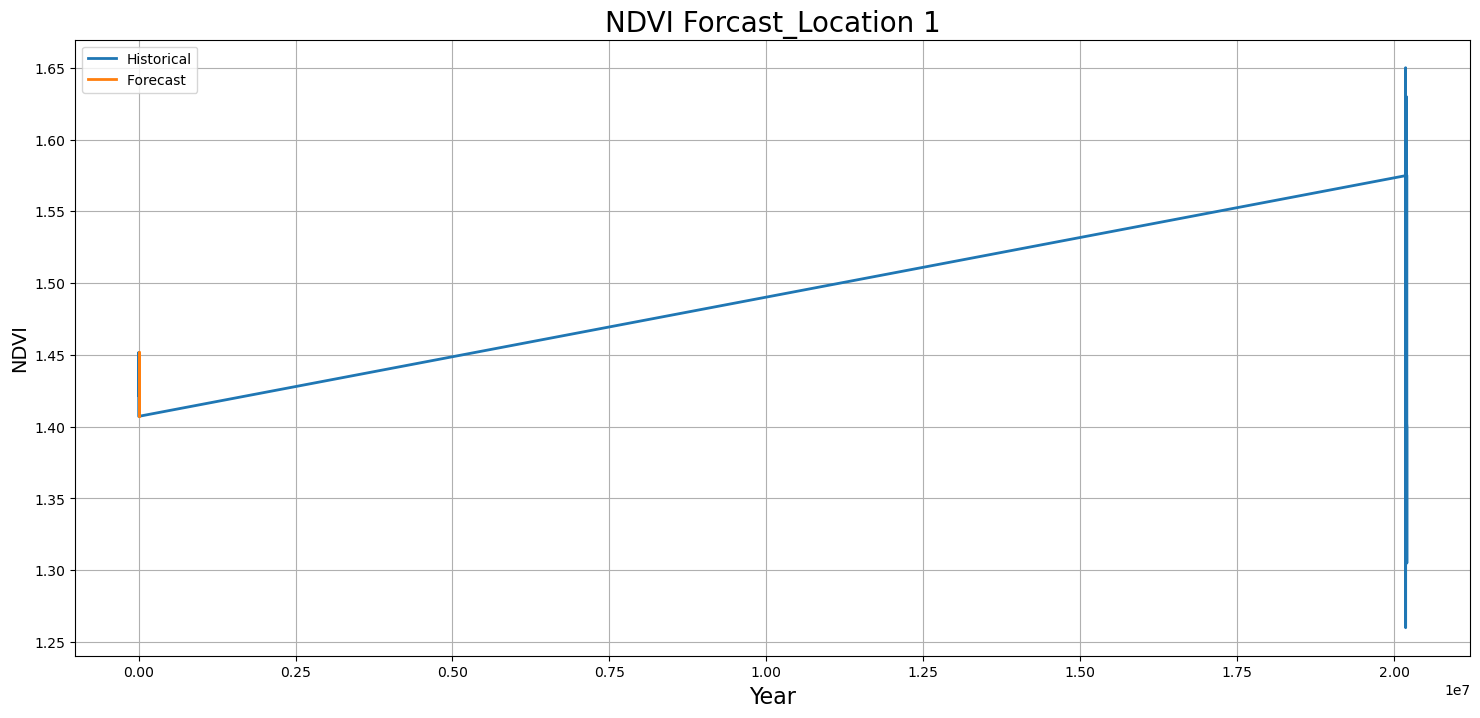

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L1_NDVI['year'], L1_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df['year'], df['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 1",fontsize=20)
ax.grid()
ax.legend();


In [100]:
L2_arr=L2_2022_2026.reshape(-1,1)
L2_arr_new=np.concatenate((year_arr, L2_arr),axis=1)
df2 = pd.DataFrame(L2_arr_new, columns = ['year','NDVI'])
L2_NDVI=year_mean.loc[year_mean['loc'] == 'L2']
L2_NDVI=pd.concat([L2_NDVI, df2], ignore_index=True)
L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)
L2_NDVI

C:\Users\smufl\AppData\Local\Temp\ipykernel_15956\291038462.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)


,year,loc,NDVI,location
0,20180122,L2,1.3400,2.0
1,20180123,L2,1.4100,2.0
2,20180124,L2,1.4500,2.0
3,20180125,L2,1.4100,2.0
4,20180126,L2,1.4200,2.0
...,...,...,...,...
736,2022,NaN,1.4072,NaN
737,2023,NaN,1.4117,NaN
738,2024,NaN,1.4517,NaN
739,2025,NaN,1.4079,NaN


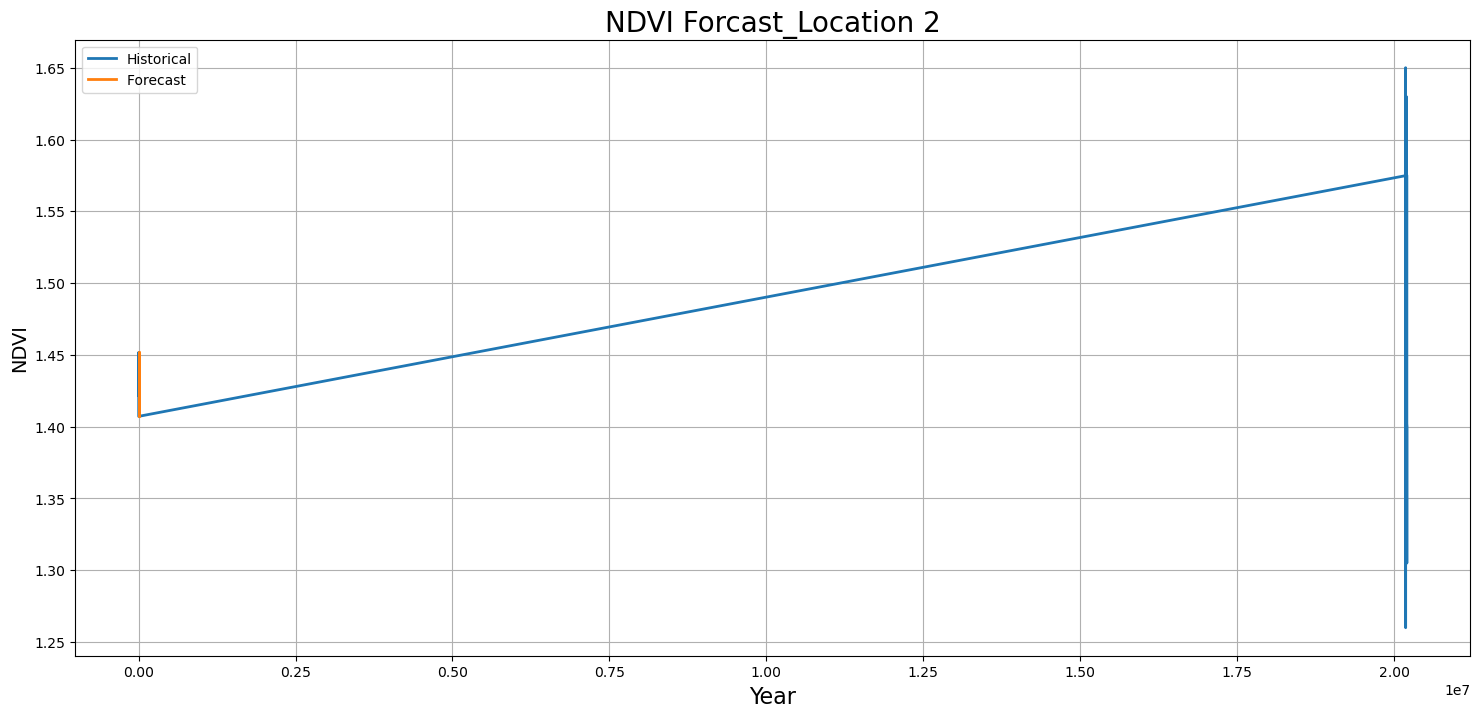

In [101]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L2_NDVI['year'], L2_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df2['year'], df2['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 2",fontsize=20)
ax.grid()
ax.legend();


# reference to codes at:

https://github.com/ledmaster/english_tutorials/blob/main/multiple_time_series/workshop_notebook.ipynb
